<a href="https://colab.research.google.com/github/uday-routhu/models/blob/master/mock_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Uday Routhu

Task
#####1.Create analytical visualizations that explore statistics for each feature for each cluster.
#####2.Write a description of each cluster based on the visualizations you created.
   - Do more than describe the numbers; try to see past the numbers and describe what kinds of people are represented by each
   - cluster. Include at least one insight for each cluster.

#####3.Create one or two recommendations for your stakeholders (the credit card company) regarding how they should market credit
   - cards differently or which cards they should market to each cluster based on your data and insights.

### Imports


In [55]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import warnings
import os

In [56]:
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [57]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
csv_file_path = "/content/drive/MyDrive/CodingDojo/03-AdvancedML/Week12/Data/flight_df - flight_df.csv"
df= pd.read_csv(csv_file_path)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                20000 non-null  int64
 1   Class                              20000 non-null  int64
 2   Flight Distance                    20000 non-null  int64
 3   Inflight wifi service              20000 non-null  int64
 4   Departure/Arrival time convenient  20000 non-null  int64
 5   Ease of Online booking             20000 non-null  int64
 6   Gate location                      20000 non-null  int64
 7   Food and drink                     20000 non-null  int64
 8   Online boarding                    20000 non-null  int64
 9   Seat comfort                       20000 non-null  int64
 10  Inflight entertainment             20000 non-null  int64
 11  On-board service                   20000 non-null  int64
 12  Leg room service  

In [60]:
df.isna().sum()

Age                                  0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Gender_Male                          0
Loyal Customer                       0
Business Travel                      0
satisfied                            0
dtype: int64

- Never use fillna() to impute values prior to Scaling, as it would cause data leakage.

In [61]:
df.describe()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Loyal Customer,Business Travel,satisfied
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,39.477250,2.027800,1188.548000,2.727950,3.056100,2.751100,2.971350,3.202100,3.255300,3.439100,...,3.623650,3.302850,3.635550,3.282650,14.318350,14.698250,0.490650,0.817850,0.687900,0.43305
std,15.108901,0.963054,1001.136957,1.326886,1.531134,1.396799,1.279575,1.332383,1.348485,1.323434,...,1.186837,1.259131,1.184017,1.311734,36.451829,36.899857,0.499925,0.385978,0.463362,0.49551
min,7.000000,1.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,27.000000,1.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000
50%,40.000000,2.000000,842.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,...,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000
75%,51.000000,3.000000,1733.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,...,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,1.000000,1.000000,1.000000,1.00000
max,85.000000,3.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,1305.000000,1280.000000,1.000000,1.000000,1.000000,1.00000


#### Scaling and Modeling

In [62]:
# Scale the data
imputer = SimpleImputer(strategy='median')
X_scaled = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
X_scaled.head()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Loyal Customer,Business Travel,satisfied
0,26.0,3.0,2062.0,2.0,3.0,3.0,3.0,2.0,2.0,2.0,...,3.0,3.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0
1,52.0,3.0,680.0,5.0,5.0,5.0,5.0,3.0,4.0,4.0,...,4.0,4.0,4.0,4.0,18.0,2.0,0.0,1.0,1.0,1.0
2,28.0,1.0,188.0,3.0,5.0,3.0,4.0,3.0,3.0,3.0,...,4.0,4.0,5.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0
3,54.0,3.0,453.0,3.0,5.0,5.0,5.0,3.0,4.0,4.0,...,3.0,4.0,3.0,1.0,91.0,80.0,0.0,1.0,1.0,0.0
4,40.0,1.0,775.0,4.0,3.0,3.0,3.0,4.0,4.0,4.0,...,3.0,3.0,3.0,4.0,0.0,0.0,1.0,1.0,1.0,0.0


#### 1. Use an Elbow Plot of inertia.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

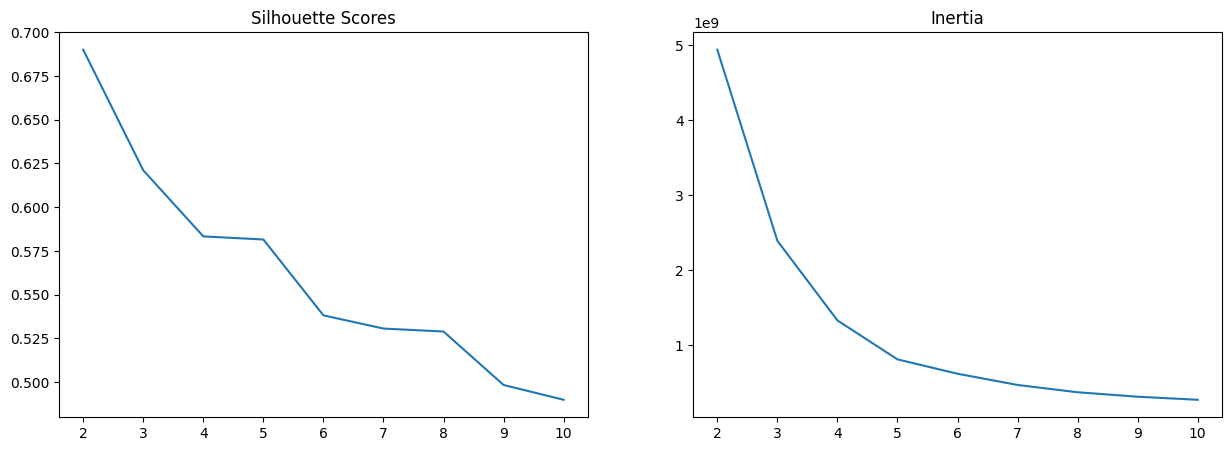

In [63]:
# Iterate over a range of k clusters to find the optimal number of clusters
ks = range(2,11)
sils = []
inertias = []
for k in ks:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(X_scaled)
  sils.append(silhouette_score(X_scaled, kmeans.labels_))
  inertias.append(kmeans.inertia_)
#plot inertias and silhouette scores for each number of clusters.
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(ks, sils)
axes[0].set_title('Silhouette Scores')
axes[0].set_xticks(ks)
axes[1].plot(ks, inertias)
axes[1].set_title('Inertia')
axes[1].set_xticks(ks);

In [64]:
# Refit KMeans with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)
# Add the clusters as a column in the dataframe
df['cluster'] = kmeans.labels_
df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Loyal Customer,Business Travel,satisfied,cluster
0,26,3,2062,2,3,3,3,2,2,2,...,3,3,2,0,0,0,1,1,0,2
1,52,3,680,5,5,5,5,3,4,4,...,4,4,4,18,2,0,1,1,1,0
2,28,1,188,3,5,3,4,3,3,3,...,4,5,3,0,0,1,1,0,0,0
3,54,3,453,3,5,5,5,3,4,4,...,4,3,1,91,80,0,1,1,0,0
4,40,1,775,4,3,3,3,4,4,4,...,3,3,4,0,0,1,1,1,0,3


#### 3.Analyzing the cluster

In [65]:
# Group the dataframe by cluster and aggregate by mean values
# Add as_index=False so that the clusters are a column, not the index
cluster_groups = df.groupby('cluster', as_index=False).mean()
cluster_groups

,cluster,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Loyal Customer,Business Travel,satisfied
0,0,38.943742,1.725137,412.454699,2.710177,3.046039,2.663822,2.964707,3.145491,3.037505,...,3.585019,3.232722,3.582385,3.190687,13.931521,14.593763,0.488306,0.760324,0.606511,0.329751
1,1,42.787879,2.975347,3422.925526,2.709296,2.890601,2.855162,2.947098,3.435028,3.913200,...,3.764766,3.451464,3.797124,3.585003,15.646636,15.971238,0.506420,0.996918,0.990241,0.776066
2,2,41.743506,2.601971,2183.939683,2.727680,2.979695,2.879367,2.992236,3.269036,3.599582,...,3.686474,3.414751,3.681397,3.436847,13.305763,13.356823,0.500746,0.948343,0.834876,0.620185
3,3,37.755948,1.856101,1127.684190,2.767460,3.185342,2.788757,2.979087,3.175173,3.184958,...,3.600921,3.303147,3.642556,3.238104,15.177283,15.274942,0.482540,0.771873,0.628741,0.372794


#### Visualizing the Clusters

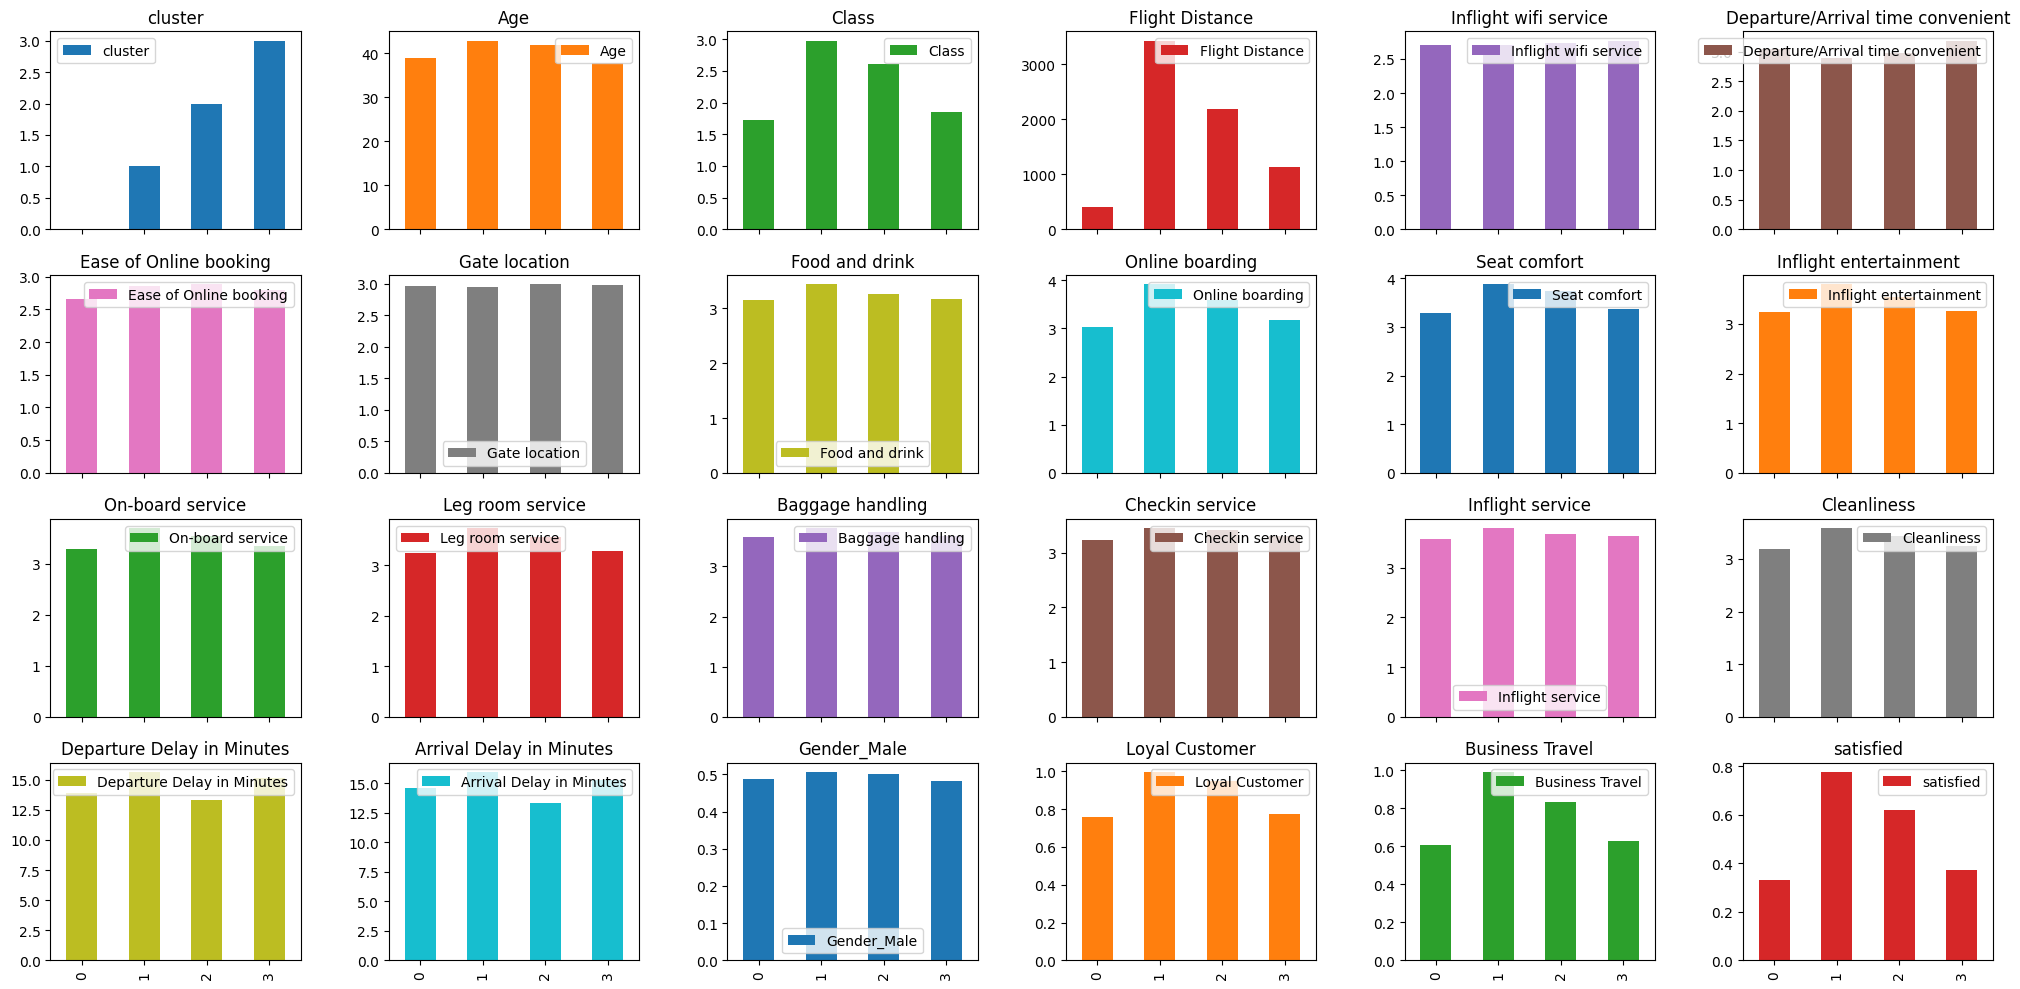

In [66]:
# Visualize means values of each column
#cluster_groups.plot(subplots=True, kind='bar', figsize=(20,10),layout =(3,4))
cluster_groups.plot(subplots=True, kind='bar', figsize=(20, 10), layout=(4, 6))
plt.tight_layout()

In [67]:
df.loc[df['cluster']==0].index

Int64Index([    1,     2,     3,     8,     9,    17,    19,    21,    24,
               25,
            ...
            19975, 19977, 19980, 19984, 19988, 19991, 19992, 19993, 19994,
            19997],
           dtype='int64', length=9492)

#### cluster0:



- This cluster has a moderate average age of around 40 years.
- The level of education (Edu) is around 1.8, indicating that the education level is relatively low to moderate.
- The average years employed is approximately 13 years.
- The average income is around :$62,362.
- The default rate is low with an average of around 0.20.
- The debt-to-income ratio is approximately 10.69.

This cluster represents customers with moderate income, average education, and a moderate amount of card debt.

#### cluster1:



- This cluster has a higher average age of around 47 years.
- The education level (Edu) is higher, around 2.3.
- The average years employed is relatively high at about 21 years.
- The average income is significantly higher at $270,900.
- The default rate is moderate with an average of around 0.43.
- The debt-to-income ratio is relatively low at 8.21.

This cluster represents financially stable customers with higher income, education, and years of employment.

#### cluster2

- The average age of this cluster is around 43 years.
- The education level (Edu) is slightly lower, around 2.2.
- The average years employed is around 19 years.
- The average income is moderate at: $122,435
- The default rate is low with an average of around 0.13.
- The debt-to-income ratio is approximately 9.15

This cluster represents customers with a balanced profile of education, income, and years of employment.

#### cluster3

- This cluster has a relatively younger average age of around 32 years.
- The education level (Edu) is lower, around 1.6.
- The average years employed is relatively low at about 5 years.
- The average income is the lowest among the clusters at $27,992.
- The default rate is moderate with an average of around 0.30.
- The debt-to-income ratio is approximately 10.11.

This cluster represents younger customers with lower income and education levels. They have relatively low card debt but a higher risk of default.

#### Recomendations

- credit card offerings to each cluster's unique characteristics and needs can help the credit card company attract a wider range of customers and enhance customer satisfaction by providing relevant benefits and features.

### Modeling

#### Split Data

In [68]:
# Save X data
X = df.drop(columns='satisfied')
# Encode our target
y = df['satisfied']

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [70]:
# Create a transformer pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Standardize the features
scaler = StandardScaler()
transformer = make_pipeline(scaler, PCA(n_components=0.95))

In [71]:
# Fit & transform data.
scaled_df = scaler.fit_transform(X)

In [72]:
# Standardize the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [73]:
# Apply PCA to retain 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [74]:
# Print the dimensions after PCA
print("Shape of X_train after PCA:", X_train_pca.shape)
print("Shape of X_test after PCA:", X_test_pca.shape)

Shape of X_train after PCA: (15000, 18)
Shape of X_test after PCA: (5000, 18)


### Transformers

In [75]:
# Categorical Preprocessing Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector, ColumnTransformer
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "Missing")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
# Numerical Preprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple],
                                 verbose_feature_names_out=False)

OneHotEncoder Columns: Index([], dtype='object')
Numeric Columns: Index(['Age', 'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'Gender_Male', 'Loyal Customer', 'Business Travel', 'cluster'],
      dtype='object')


In [76]:
# process the data
#X_train_processed = preprocessor.fit_transform(X_train)
#X_test_processed = preprocessor.transform(X_test)

### Model 1

In [77]:
# create and compile the model
from tensorflow import keras
from keras.layers import Dense

model = keras.Sequential()
model.add(Dense(10, input_dim=X_train_pca.shape[1], activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model and save the history
history = model.fit(X_train_pca, y_train, validation_split=0.2, epochs=10)

Epoch 1/10
375/375 [==============================] - 1s 2ms/step - loss: 0.5566 - accuracy: 0.7338 - val_loss: 0.3919 - val_accuracy: 0.8517
Epoch 2/10
375/375 [==============================] - 1s 2ms/step - loss: 0.3345 - accuracy: 0.8712 - val_loss: 0.3118 - val_accuracy: 0.8810
Epoch 3/10
375/375 [==============================] - 1s 2ms/step - loss: 0.2945 - accuracy: 0.8859 - val_loss: 0.2863 - val_accuracy: 0.8907
Epoch 4/10
375/375 [==============================] - 1s 2ms/step - loss: 0.2746 - accuracy: 0.8917 - val_loss: 0.2685 - val_accuracy: 0.8973
Epoch 5/10
375/375 [==============================] - 1s 2ms/step - loss: 0.2600 - accuracy: 0.8978 - val_loss: 0.2581 - val_accuracy: 0.8983
Epoch 6/10
375/375 [==============================] - 1s 2ms/step - loss: 0.2487 - accuracy: 0.8998 - val_loss: 0.2490 - val_accuracy: 0.9027
Epoch 7/10
375/375 [==============================] - 1s 2ms/step - loss: 0.2400 - accuracy: 0.9038 - val_loss: 0.2413 - val_accuracy: 0.9070
Epoch 

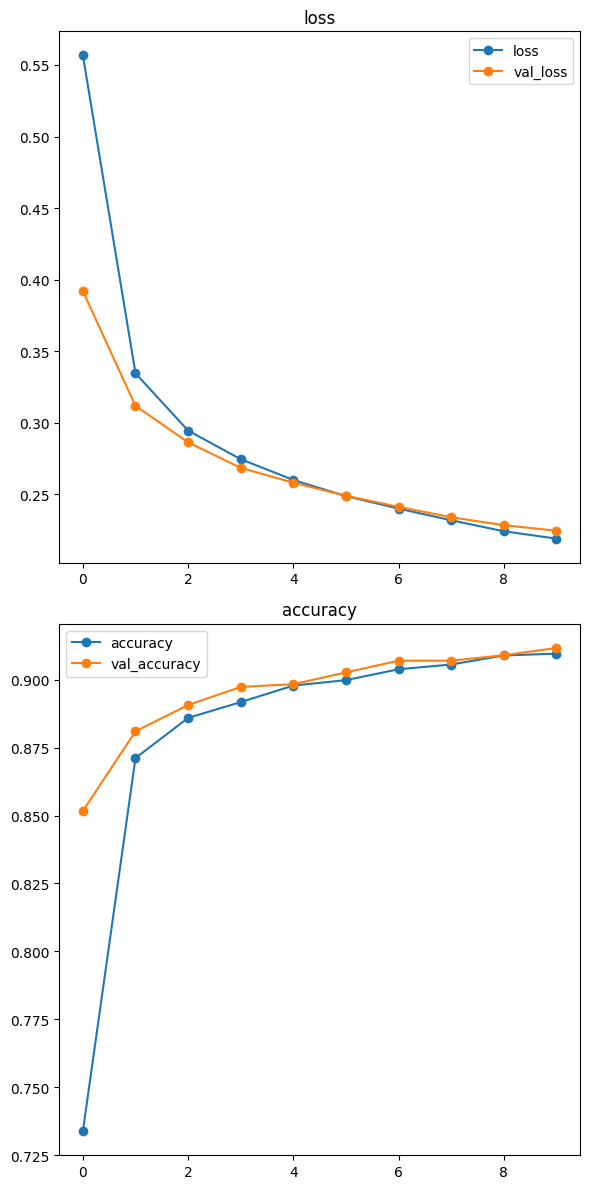

In [78]:
# Call the custom function
#import matplotlib.pyplot as plt
plot_history(history);

In [79]:
# Evaluate neural network with builtin evaluation
result = model.evaluate(X_test_pca, y_test,return_dict=True)
result

157/157 [==============================] - 0s 1ms/step - loss: 0.2170 - accuracy: 0.9116


{'loss': 0.21702514588832855, 'accuracy': 0.9115999937057495}

157/157 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      2835
           1       0.92      0.87      0.89      2165

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000



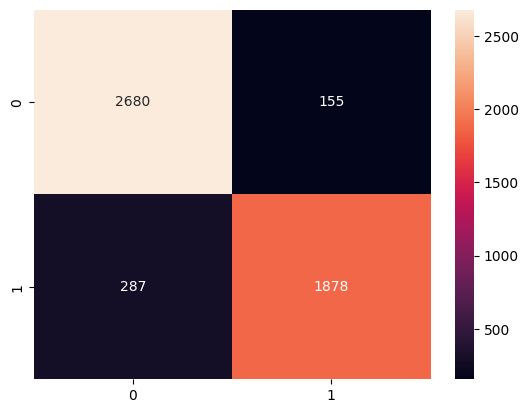

In [80]:
# evaluate the model with sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
test_preds = model.predict(X_test_pca).round()
print(classification_report(y_test, test_preds))
conf_mat = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_mat, annot=True, fmt ='g');

#### Model2

In [81]:
# create model
model2 = keras.Sequential()
model2.add(Dense(20, input_dim=X_train_pca.shape[1],
          activation = 'relu'))
model2.add(Dense(5, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))

model2.compile(optimizer = 'adam', loss = 'bce', metrics = 'accuracy')

In [82]:
# train the model and save the history
history = model2.fit(X_train_pca, y_train,validation_split=0.2,epochs = 10)

Epoch 1/10
375/375 [==============================] - 2s 2ms/step - loss: 0.4517 - accuracy: 0.8152 - val_loss: 0.3188 - val_accuracy: 0.8823
Epoch 2/10
375/375 [==============================] - 1s 3ms/step - loss: 0.3030 - accuracy: 0.8843 - val_loss: 0.2767 - val_accuracy: 0.8910
Epoch 3/10
375/375 [==============================] - 1s 2ms/step - loss: 0.2638 - accuracy: 0.8982 - val_loss: 0.2458 - val_accuracy: 0.9037
Epoch 4/10
375/375 [==============================] - 1s 2ms/step - loss: 0.2356 - accuracy: 0.9053 - val_loss: 0.2288 - val_accuracy: 0.9090
Epoch 5/10
375/375 [==============================] - 1s 2ms/step - loss: 0.2188 - accuracy: 0.9108 - val_loss: 0.2208 - val_accuracy: 0.9067
Epoch 6/10
375/375 [==============================] - 1s 1ms/step - loss: 0.2088 - accuracy: 0.9145 - val_loss: 0.2171 - val_accuracy: 0.9097
Epoch 7/10
375/375 [==============================] - 1s 2ms/step - loss: 0.2018 - accuracy: 0.9163 - val_loss: 0.2143 - val_accuracy: 0.9143
Epoch 

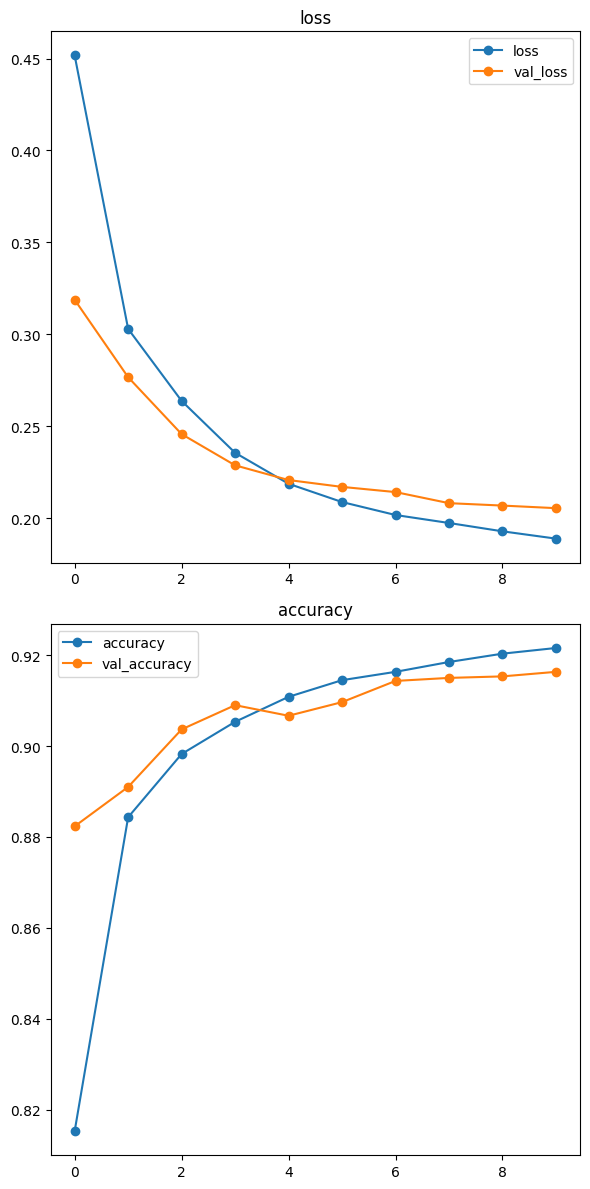

In [83]:
plot_history(history);

In [85]:
# Evaluate neural network with builtin evaluation
result = model2.evaluate(X_test_pca, y_test,return_dict=True)
result

157/157 [==============================] - 0s 2ms/step - loss: 0.1971 - accuracy: 0.9208


{'loss': 0.1970922350883484, 'accuracy': 0.920799970626831}

157/157 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2835
           1       0.92      0.89      0.91      2165

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



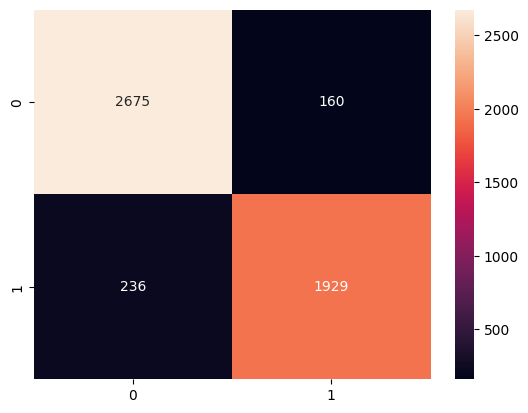

In [86]:
# evaluate the model with sklearn metrics
test_preds = model2.predict(X_test_pca).round()
print(classification_report(y_test, test_preds))
conf_mat = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_mat, annot=True, fmt = 'g');

### Model 3: More layers

In [92]:
# create model
model3 = keras.Sequential()
model3.add(Dense(20, input_dim=X_train_pca.shape[1],activation = 'relu')) # Increased nodes in the first layer
model3.add(Dense(5, activation = 'relu')) # Added an extra hidden layer with ReLU activation
model3.add(Dense(5, activation = 'relu')) # Added another hidden layer with ReLU activation
model3.add(Dense(1, activation = 'sigmoid')) # Output layer remains the same for binary classification

model3.compile(optimizer = 'adam', loss = 'bce', metrics = 'accuracy') # Compiled the model with 'adam' optimizer and 'bce' (Binary Cross-Entropy) loss

In [88]:
# train the model and save the history
history = model3.fit(X_train_pca, y_train,
          validation_split = .2,
          epochs = 10)

Epoch 1/10
375/375 [==============================] - 2s 3ms/step - loss: 0.4914 - accuracy: 0.7844 - val_loss: 0.3217 - val_accuracy: 0.8747
Epoch 2/10
375/375 [==============================] - 1s 2ms/step - loss: 0.2938 - accuracy: 0.8893 - val_loss: 0.2657 - val_accuracy: 0.9003
Epoch 3/10
375/375 [==============================] - 1s 2ms/step - loss: 0.2503 - accuracy: 0.9031 - val_loss: 0.2389 - val_accuracy: 0.9033
Epoch 4/10
375/375 [==============================] - 1s 2ms/step - loss: 0.2216 - accuracy: 0.9133 - val_loss: 0.2176 - val_accuracy: 0.9137
Epoch 5/10
375/375 [==============================] - 1s 2ms/step - loss: 0.2063 - accuracy: 0.9146 - val_loss: 0.2107 - val_accuracy: 0.9160
Epoch 6/10
375/375 [==============================] - 1s 2ms/step - loss: 0.1971 - accuracy: 0.9189 - val_loss: 0.2065 - val_accuracy: 0.9187
Epoch 7/10
375/375 [==============================] - 1s 2ms/step - loss: 0.1904 - accuracy: 0.9200 - val_loss: 0.2033 - val_accuracy: 0.9187
Epoch 

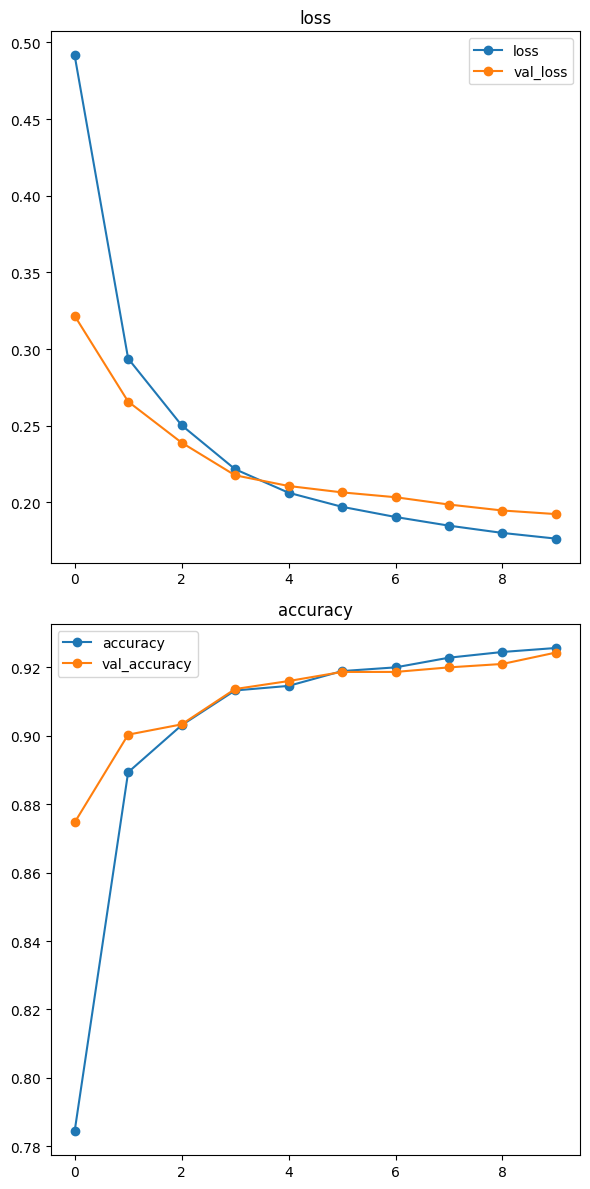

In [89]:
# Obtain history
plot_history(history);

In [90]:
# Evaluate neural network with builtin evaluation
result = model3.evaluate(X_test_pca, y_test,return_dict=True)
result

157/157 [==============================] - 1s 2ms/step - loss: 0.1812 - accuracy: 0.9278


{'loss': 0.18124805390834808, 'accuracy': 0.9277999997138977}

157/157 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      2835
           1       0.92      0.91      0.92      2165

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



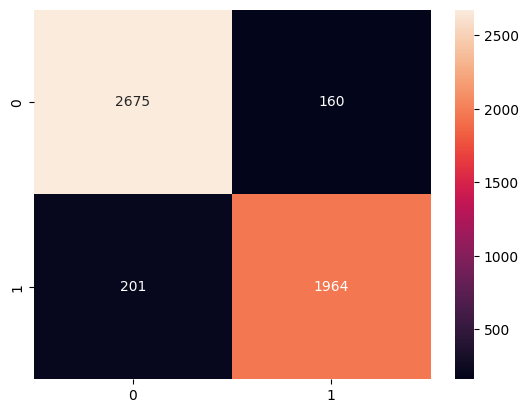

In [91]:
# evaluate the model
test_preds = model3.predict(X_test_pca).round()
print(classification_report(y_test, test_preds))
conf_mat = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_mat, annot=True, fmt ='g');